# Build a Movie Recommendation Engine with Apache Spark & Elasticsearch

In this notebook, the aim is building a movie recommendation engine using Spark and Elasticsearch with movie rating data from Netflix.
I train an alternative least square (**ALS**) model in Spark and export the model to Elasticsearch to display the recommendation results.


## Overview

Working steps

1. Prepare the data
2. Use the Elasticsearch Spark connector to save data to Elasticsearch
3. Load ratings data and train an ALS recommendation model using Spark ML
3. Save the model to Elasticsearch
4. Show recommendations using Elasticsearch vector scoring plugin

## Step 1: Prepare the data

### 1(a) Data ETL and Exploration

In [2]:
# first import a few utility methods that we'll use later on
from IPython.display import Image, HTML, display
# check PySpark is running
spark

In [3]:
import math
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import re
import seaborn as sns

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

### Load rating and movie data

In [5]:
movies = spark.read.load("../../../ml-latest/movies.csv", format='csv', header = True)
ratings = spark.read.load("../../../ml-latest/ratings.csv", format='csv', header = True)
links = spark.read.load("../../../ml-latest/links.csv", format='csv', header = True)
tags = spark.read.load("../../../ml-latest/tags.csv", format='csv', header = True)

In [6]:
print("Number of ratings: %i" % ratings.count())
print("Sample of ratings:")
ratings.show(5)

Number of ratings: 27753444
Sample of ratings:
+------+-------+------+----------+
|userId|movieId|rating| timestamp|
+------+-------+------+----------+
|     1|    307|   3.5|1256677221|
|     1|    481|   3.5|1256677456|
|     1|   1091|   1.5|1256677471|
|     1|   1257|   4.5|1256677460|
|     1|   1449|   4.5|1256677264|
+------+-------+------+----------+
only showing top 5 rows



We need to convert `timestamp` from a **UNIX** timestamp in seconds to that in **milliseconds** in order to match the requirement of Elasticsearch

In [7]:
ratings = ratings.select(
    ratings.userId, ratings.movieId, ratings.rating, (ratings.timestamp.cast("long") * 1000).alias("timestamp"))
ratings.show(5)

+------+-------+------+-------------+
|userId|movieId|rating|    timestamp|
+------+-------+------+-------------+
|     1|    307|   3.5|1256677221000|
|     1|    481|   3.5|1256677456000|
|     1|   1091|   1.5|1256677471000|
|     1|   1257|   4.5|1256677460000|
|     1|   1449|   4.5|1256677264000|
+------+-------+------+-------------+
only showing top 5 rows



In [8]:
print("information about ratings:")
ratings.describe().show()

information about ratings:
+-------+------------------+------------------+------------------+--------------------+
|summary|            userId|           movieId|            rating|           timestamp|
+-------+------------------+------------------+------------------+--------------------+
|  count|          27753444|          27753444|          27753444|            27753444|
|   mean|141942.01557064414| 18487.99983414671|3.5304452124932677|1.193121854931938...|
| stddev|   81707.400091494|35102.625247468335| 1.066352750231989| 2.16048228522343E11|
|    min|                 1|                 1|               0.5|        789652004000|
|    max|             99999|             99999|               5.0|       1537945149000|
+-------+------------------+------------------+------------------+--------------------+



In [9]:
print("there is %d null in ratings" % ratings.where(ratings['rating'].isNull()).count())

there is 0 null in ratings


In [10]:
tmp_user_min = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp_user_max = ratings.groupBy("userID").count().toPandas()['count'].max()
tmp_movie_min = ratings.groupBy("movieId").count().toPandas()['count'].min()
tmp_movie_max = ratings.groupBy("movieId").count().toPandas()['count'].max()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp_user_min))
print('Maximum number of ratings per user is {}'.format(tmp_user_max))
print('Minimum number of ratings per movie is {}'.format(tmp_movie_min))
print('Maximum number of ratings per movie is {}'.format(tmp_movie_max))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 1
Maximum number of ratings per user is 23715
Minimum number of ratings per movie is 1
Maximum number of ratings per movie is 97999


In [11]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

10155 out of 53889 movies are rated by only one user


In [12]:
movies.show(5, truncate=False)

+-------+----------------------------------+-------------------------------------------+
|movieId|title                             |genres                                     |
+-------+----------------------------------+-------------------------------------------+
|1      |Toy Story (1995)                  |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji (1995)                    |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men (1995)           |Comedy|Romance                             |
|4      |Waiting to Exhale (1995)          |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II (1995)|Comedy                                     |
+-------+----------------------------------+-------------------------------------------+
only showing top 5 rows



In [13]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *

### Split the release year from title so that it can be used as filter for recommendation engine.

In [14]:
import re
# define a UDF to extract the release year from the title, and return the new title and year in a struct type
def extract_year_fn(title):
    result = re.search("\(\d{4}\)", title)
    try:
        if result:
            group = result.group()
            year = group[1:-1]
            start_pos = result.start()
            title = title[:start_pos-1]
            return (title, year)
        else:
            return (title, None)
    except:
        print(title)

extract_year = udf(extract_year_fn,\
                   StructType([StructField("title", StringType(), True),\
                               StructField("release_date", StringType(), True)]))


In [15]:
movies = movies.select(
    "movieId", extract_year("title").title.alias("title"),\
    extract_year("title").release_date.alias("release_date"),\
    "genres")
print("Cleaned movie data:")
movies.show(5, truncate=False)

Cleaned movie data:
+-------+---------------------------+------------+-------------------------------------------+
|movieId|title                      |release_date|genres                                     |
+-------+---------------------------+------------+-------------------------------------------+
|1      |Toy Story                  |1995        |Adventure|Animation|Children|Comedy|Fantasy|
|2      |Jumanji                    |1995        |Adventure|Children|Fantasy                 |
|3      |Grumpier Old Men           |1995        |Comedy|Romance                             |
|4      |Waiting to Exhale          |1995        |Comedy|Drama|Romance                       |
|5      |Father of the Bride Part II|1995        |Comedy                                     |
+-------+---------------------------+------------+-------------------------------------------+
only showing top 5 rows



Next, join the `links` data to `movies` to get tmdbId which can be used to retrieve movie poster images when displaying recommendations later.

In [16]:
# join movies with links to get TMDB id
movie_data = movies.join(links, movies.movieId == links.movieId)\
    .select(movies.movieId, movies.title, movies.release_date, movies.genres, links.tmdbId)
num_movies = movie_data.count()
print("Cleaned movie data with tmdbId links:")
movie_data.show(5, truncate=False)

Cleaned movie data with tmdbId links:
+-------+---------------------------+------------+-------------------------------------------+------+
|movieId|title                      |release_date|genres                                     |tmdbId|
+-------+---------------------------+------------+-------------------------------------------+------+
|1      |Toy Story                  |1995        |Adventure|Animation|Children|Comedy|Fantasy|862   |
|2      |Jumanji                    |1995        |Adventure|Children|Fantasy                 |8844  |
|3      |Grumpier Old Men           |1995        |Comedy|Romance                             |15602 |
|4      |Waiting to Exhale          |1995        |Comedy|Drama|Romance                       |31357 |
|5      |Father of the Bride Part II|1995        |Comedy                                     |11862 |
+-------+---------------------------+------------+-------------------------------------------+------+
only showing top 5 rows



### 1(b) Spark SQL and OLAP

In [17]:
ratings = ratings.withColumn("userId", ratings["userId"].cast(LongType()))
ratings = ratings.withColumn("movieId", ratings["movieId"].cast(LongType()))
ratings = ratings.withColumn("rating", ratings["rating"].cast(FloatType()))

In [18]:
movies.createOrReplaceTempView('movies')
ratings.createOrReplaceTempView('ratings')

In [19]:
from IPython.core.magic import register_line_cell_magic

max_show_lines = 20         # Limit on the number of lines to show with %sql_show and %sql_display

@register_line_cell_magic
def sql(line, cell=None):
    "Return a Spark DataFrame for lazy evaluation of the sql. Use: %sql or %%sql"
    val = cell if cell is not None else line 
    return spark.sql(val)

@register_line_cell_magic
def sql_show(line, cell=None):
    "Execute sql and show the first max_show_lines lines. Use: %sql_show or %%sql_show"
    val = cell if cell is not None else line 
    return spark.sql(val).show(max_show_lines)

@register_line_cell_magic
def sql_display(line, cell=None):
    """Execute sql and convert results to Pandas DataFrame for pretty display or further processing.
    Use: %sql_display or %%sql_display"""
    val = cell if cell is not None else line 
    return spark.sql(val).limit(max_show_lines).toPandas() 

### The number of users

In [20]:
num_user = ratings.select('userId').distinct().count()
num_rating = ratings.select('rating').count()
print('number of users are: {}'.format(num_user))
print('total rating number is: {}'.format(num_rating))

number of users are: 283228
total rating number is: 27753444


### The number of movies

In [21]:
num_mv = movies.select('movieId').distinct().count()
print('number of Movies are: {}'.format(num_mv))

number of Movies are: 58098


### Number of movies rated by users. Also list movies not rated before (for better visualization, only show 20 movies of them).

In [22]:
%%sql_show

Select count(distinct movieId) as rated_num
From ratings
Where rating is not null

+---------+
|rated_num|
+---------+
|    53889|
+---------+



In [23]:
%%sql_display

Select distinct m.movieId, title
From movies m
Left Join ratings r on m.movieId=r.movieId
Where r.rating is null
Order by movieId

,movieId,title
0,100609,Fambul Tok
1,100642,Sunday Lovers
2,101216,Shadow Boxers
3,101229,May the Best Man Win
4,101237,9500 Liberty
5,101369,Shadow Zone: My Teacher Ate My Homework
6,101391,"Ascent, The"
7,101407,Laffghanistan: Comedy Down Range
8,101437,"Baby Dance, The"
9,101441,"Inspectors 2: A Shred of Evidence, The"


### Conclusion 1

In this dataset, we have 58098 movies, only 53889 of them are rated. There are 4209 of them are not rated by users.

### List movie genres

In [24]:
%%sql_display

Select distinct explode(split(genres,'\\|')) as categories
From movies

,categories
0,Crime
1,Romance
2,Thriller
3,Adventure
4,Drama
5,War
6,Documentary
7,Fantasy
8,Mystery
9,Musical


### Number of movies and average rating for each category

In [25]:
categories = spark.sql(
                   '''Select cte.category, count(*) as rate_num, avg(rating) as avg_rate
                      From movies m
                      Join
                        (Select movieId, title, explode(split(genres,'\\\\|')) as category
                        From movies) cte
                      on m.movieId=cte.movieId
                      Join ratings r on m.movieId=r.movieId
                      Group by cte.category
                      Order by 2 Desc''')

In [26]:
categories.show()

+------------------+--------+------------------+
|          category|rate_num|          avg_rate|
+------------------+--------+------------------+
|             Drama|12191048|3.6763707271105814|
|            Comedy| 9999184| 3.419786704595095|
|            Action| 8214956|3.4625655329133838|
|          Thriller| 7489628|3.5188010672893233|
|         Adventure| 6452309|3.5132836167641694|
|           Romance| 5078478| 3.541861853098507|
|            Sci-Fi| 4740208|3.4704759791131528|
|             Crime| 4631581| 3.683522430029832|
|           Fantasy| 3118549|  3.50720832027972|
|          Children| 2381124| 3.423892875801512|
|           Mystery| 2210388|3.6655695742105006|
|            Horror| 2070791|3.2843780468429697|
|         Animation| 1803041| 3.607309262518157|
|               War| 1426112| 3.796596971345869|
|           Musical| 1109674|3.5427517451071218|
|              IMAX| 1102179|3.6189756836230775|
|           Western|  542424|3.5776726324793886|
|       Documentary|

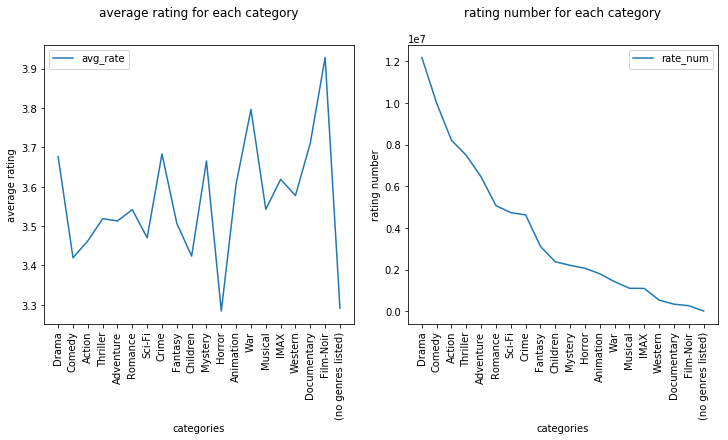

In [108]:
fig, (ax1, ax2) = plt.subplots(figsize=(10,6), ncols=2, constrained_layout=True)
categories_p = categories.toPandas()

xticks = [cate[0] for cate in categories.select("category").collect()]

ax1.plot('category','avg_rate',data=categories_p)
# plt.plot('iter_num','validation_mse',data=categories_p)
ax1.set_xlabel("categories")
ax1.set_xticklabels(xticks,rotation=90)
ax1.set_ylabel("average rating")
ax1.set_title("average rating for each category", y=1.08)
ax1.legend()

ax2.plot('category','rate_num',data=categories_p)
ax2.set_xlabel("categories")
ax2.set_xticklabels(xticks,rotation=90)
ax2.set_ylabel("rating number")
ax2.set_title("rating number for each category", y=1.08)
ax2.legend()

# fig.show()

### Conclusion 2

We have 20 categories of movies in the dataset. **Drama**, **Comedy** and **Action** are top 3 categories received most rating (around 10 million) by users. **Drama**, **Crime**, **Mystery**, **War** and **Film-Noir** are categories rated by relatively higher score. The average rating scores for all these categories are between 3.3 and 3.9 (rating in 0-5 range).

### Number of each rating score

In [28]:
rating_scores = spark.sql(
                    '''Select rating, count(*) as num
                    From ratings
                    Group by rating
                    Order by 1''')

Text(0.5,1,'Number of each rating score')

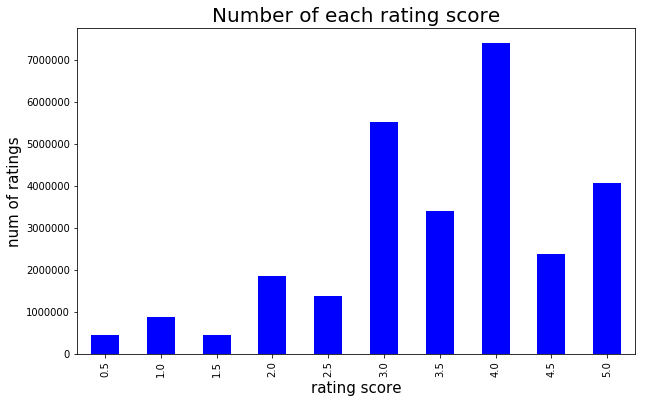

In [29]:
rating_scores.toPandas().plot(figsize = (10,6), kind = "bar", color = "blue",
                               x = "rating", y = "num", legend = False)

plt.xlabel("rating score", fontsize = 15)
plt.ylabel("num of ratings", fontsize = 15)
plt.title("Number of each rating score", fontsize = 20)

### Top 1000 movies received the largest number of ratings

In [30]:
top_rating_num = spark.sql(
                '''Select r.movieId, m.title, m.release_date, sum(case when rating is not null then 1 else 0 end) as rate_num
                From ratings r
                Join movies m on r.movieId=m.movieId
                Group by 1,2,3
                Order by 4 desc
                Limit 1000''')

top_rating_num.createOrReplaceTempView('top_rate_num_movies')

top_rating_num.limit(15).toPandas().head(15)

,movieId,title,release_date,rate_num
0,318,"Shawshank Redemption, The",1994,97999
1,356,Forrest Gump,1994,97040
2,296,Pulp Fiction,1994,92406
3,593,"Silence of the Lambs, The",1991,87899
4,2571,"Matrix, The",1999,84545
5,260,Star Wars: Episode IV - A New Hope,1977,81815
6,480,Jurassic Park,1993,76451
7,527,Schindler's List,1993,71516
8,110,Braveheart,1995,68803
9,1,Toy Story,1995,68469


In [31]:
top_rating_movies_by_year = spark.sql(
                                '''Select release_date, count(*) as num_by_year
                                    From top_rate_num_movies
                                    Group by release_date
                                    Order by 2 Desc
                                    Limit 10''')

Text(0.5,1,'Top 10 years with the largest number of top rated movies')

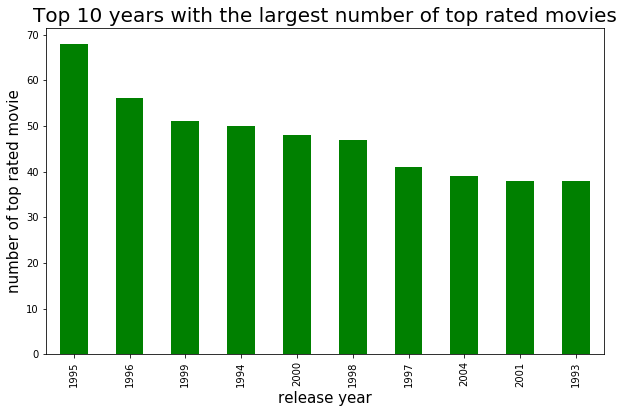

In [106]:
top_rating_movies_by_year.toPandas().plot(figsize = (10,6), kind = "bar", color = "green",
                               x = "release_date", y = "num_by_year", legend = False)

plt.xlabel("release year", fontsize = 15)
plt.ylabel("number of top rated movie", fontsize = 15)
plt.title("Top 10 years with the largest number of top rated movies", fontsize = 20)

In [33]:
top_rating_movies_by_decade = spark.sql(
                '''Select (case when release_date<1970 then 'before 1970' when release_date between 1970 and 1979 then '1970s' when release_date between 1980 and 1989 then '1980s'
                        when release_date between 1990 and 1999 then '1990s' when release_date between 2000 and 2009 then '2000s' else 'after 2010' end) as decade, count(*) as num_by_decade
                From top_rate_num_movies
                Group by 1
                Order by 2 Desc''')

Text(0.5,1,'Decades with the most number of top rated movies')

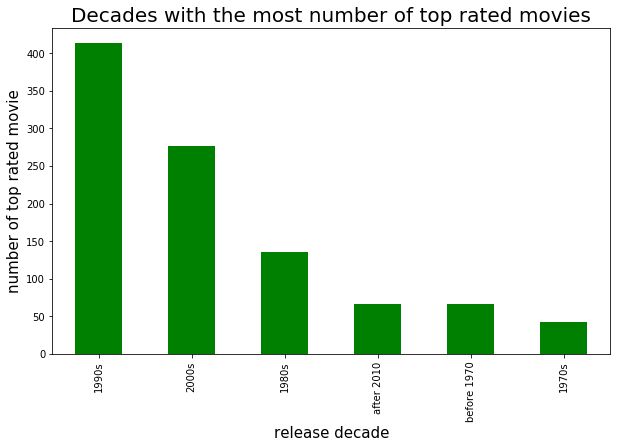

In [107]:
top_rating_movies_by_decade.toPandas().plot(figsize = (10,6), kind = "bar", color = "green",
                               x = "decade", y = "num_by_decade", legend = False)

plt.xlabel("release decade", fontsize = 15)
plt.ylabel("number of top rated movie", fontsize = 15)
plt.title("Decades with the most number of top rated movies", fontsize = 20)

 ### Top 1000 movies with highest average rating (received over 1000 ratings)

In [35]:
top_avg_rating_movies = spark.sql(
                  '''Select r.movieId, m.title, m.release_date, round(avg(rating), 2) as avg_rate, sum(case when r.rating is not null then 1 else 0 end) as rate_num
                  From ratings r
                  Join movies m on r.movieId=m.movieId
                  Group by 1,2,3
                  Having sum(case when r.rating is not null then 1 else 0 end)>=1000
                  Order by 4 desc
                  Limit 1000''')

top_avg_rating_movies.createOrReplaceTempView('top_avg_rate_movies')

top_avg_rating_movies.limit(15).toPandas().head(15)

,movieId,title,release_date,avg_rate,rate_num
0,159817,Planet Earth,2006,4.46,1384
1,318,"Shawshank Redemption, The",1994,4.42,97999
2,174053,Black Mirror: White Christmas,2014,4.35,1074
3,858,"Godfather, The",1972,4.33,60904
4,50,"Usual Suspects, The",1995,4.29,62180
5,1221,"Godfather: Part II, The",1974,4.26,38875
6,527,Schindler's List,1993,4.26,71516
7,2019,Seven Samurai (Shichinin no samurai),1954,4.25,14578
8,1203,12 Angry Men,1957,4.24,17931
9,904,Rear Window,1954,4.23,22264


In [36]:
top_avg_score_movie_by_decade = spark.sql(
            '''Select (case when release_date<1970 then 'before 1970' when release_date between 1970 and 1979 then '1970s' when release_date between 1980 and 1989 then '1980s' when release_date between 1990 and 1999 then '1990s'
            when release_date between 2000 and 2009 then '2000s' else 'after 2010' end) as decade, count(*) as num_by_decade, round(sum(avg_rate*rate_num)/sum(rate_num), 2) as avg_score_by_decade
            From top_avg_rate_movies
            Group by 1
            Order by 2 Desc, 3 Desc''')

Text(0.5,1,'Decades with number of highest average score movies')

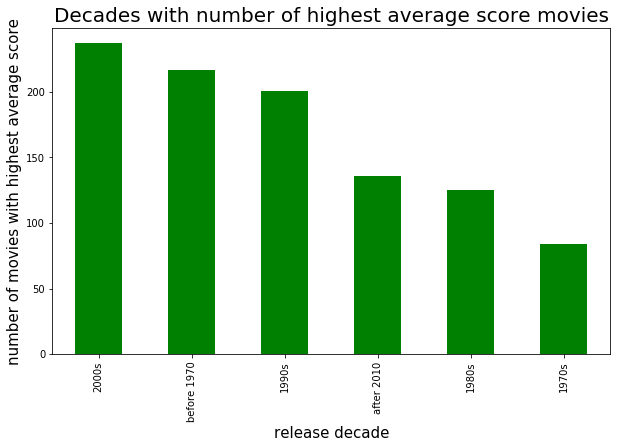

In [37]:
top_avg_score_movie_by_decade.toPandas().plot(figsize = (10,6), kind = "bar", color = "green",
                               x = "decade", y = "num_by_decade", legend = False)

plt.xlabel("release decade", fontsize = 15)
plt.ylabel("number of movies with highest average score", fontsize = 15)
plt.title("Decades with number of highest average score movies", fontsize = 20)

### Conclusion 3

Rating scores are mainly distributed between 3.0 and 5.0.   
The top 3 most popular movies are 'Shawshank Redemption', 'Forrest Gump' and 'Pulp Fiction' which receive more than 90,000 rating.   
1990s has 413 of top 1000 popular movies (received most rating in this dataset).   
'Planet Earth', 'Shawshank Redemption' and 'Black Mirror: White Christmas' are the top 3 movies with the highest average rating score around 4.4. While 'Shawshank Redemption', 'The Godfather' and 'The Usual Suspects' are movies both received high number of rating and average rating score. These movies should be recommended to users in general.

## Step 2: Load data into Elasticsearch

In [38]:
from elasticsearch import Elasticsearch

# test ES instance is running
es = Elasticsearch()
es.info(pretty=True)

{'name': 'sMs7zzC',
 'cluster_name': 'elasticsearch',
 'cluster_uuid': 'ZNmUzgnOQmWID6ZzZz-H7Q',
 'version': {'number': '5.3.0',
  'build_hash': '3adb13b',
  'build_date': '2017-03-23T03:31:50.652Z',
  'build_snapshot': False,
  'lucene_version': '6.4.1'},
 'tagline': 'You Know, for Search'}

### Create an Elasticsearch index with mappings for users, movies and rating events

In [44]:
# es.indices.delete(index="ratings")
# es.indices.delete(index="users")
# es.indices.delete(index="movies")

{'acknowledged': True}

In [45]:
index_rating = {   "settings": {
                },
                "mappings": {
                    "doc": {
                      # this mapping definition sets up the fields for the rating events
                      "properties": {
                            "timestamp": {"type": "date"},
                            "userId": {"type": "integer"},
                            "movieId": {"type": "integer"},
                            "rating": {"type": "double"}
                        }  
                    }
                }
            }

index_user = {   "settings": {
                    "analysis": {
                            "analyzer": {
                                # this configures the custom analyzer we need to parse vectors such that the scoring
                                # plugin will work correctly
                                "payload_analyzer": {
                                    "type": "custom",
                                    "tokenizer":"whitespace",
                                    "filter":"delimited_payload_filter"}
                                }
                            }
                    },
                  "mappings": {
                        "doc": {
                        # this mapping definition sets up the metadata fields for the users
                        "properties": {
                            "userId": {"type": "integer"},
                            "@model": {
                                # this mapping definition sets up the fields for user factor vectors of our model
                                "properties": {
                                    "factor": {
                                        "type": "text",
                                        "term_vector": "with_positions_offsets_payloads",
                                        "analyzer" : "payload_analyzer"},
                                    "version": {"type": "keyword"},
                                    "timestamp": {"type": "date"}
                                    }
                                }
                            }
                         }
                      }
             }



index_movie = {   "settings": {
                    "analysis": {
                            "analyzer": {
                                # this configures the custom analyzer we need to parse vectors such that the scoring
                                # plugin will work correctly
                                "payload_analyzer": {
                                    "type": "custom",
                                    "tokenizer":"whitespace",
                                    "filter":"delimited_payload_filter"}
                                }
                            }
                    },
                  "mappings": {
                        "doc": {
                        # this mapping definition sets up the metadata fields for the users
                        "properties": {
                            "movieId": {"type": "integer"},
                            "tmdbId": {"type": "keyword"},
                            "genres": {"type": "keyword"},
                            "release_date": {
                                "type": "date",
                                "format": "year"},
                            "@model": {
                                # this mapping definition sets up the fields for user factor vectors of our model
                                "properties": {
                                    "factor": {
                                        "type": "text",
                                        "term_vector": "with_positions_offsets_payloads",
                                        "analyzer" : "payload_analyzer"},
                                    "version": {"type": "keyword"},
                                    "timestamp": {"type": "date"}
                                    }
                                }
                            }
                         }
                      }
             }

In [46]:
es.indices.create(index="ratings", body=index_rating)
es.indices.create(index="users", body=index_user)
es.indices.create(index="movies", body=index_movie)

{'acknowledged': True, 'shards_acknowledged': True}

### Load Ratings and Movies DataFrames into Elasticsearch

### It may takes more than 20 minutes to write ratings data into ES

In [47]:
# write ratings data
ratings.write.format("es").save("ratings/doc")
# check write went ok
print("Dataframe count: %d" % ratings.count())
print("ES index count:  %d" % es.count(index="ratings")['count'])

Dataframe count: 27753444
ES index count:  27753444


In [105]:
# test things out by retrieving a few rating event documents from Elasticsearch
es.search(index="ratings", q="rating:>=4.0", size=3)

{'took': 154,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'failed': 0},
 'hits': {'total': 13839395,
  'max_score': 1.0,
  'hits': [{'_index': 'ratings',
    '_type': 'doc',
    '_id': 'AW_GKUGnTb0S9uypxgRL',
    '_score': 1.0,
    '_source': {'userId': 153268,
     'movieId': 68157,
     'rating': 4.5,
     'timestamp': 1470609443000}},
   {'_index': 'ratings',
    '_type': 'doc',
    '_id': 'AW_GKUGnTb0S9uypxgRO',
    '_score': 1.0,
    '_source': {'userId': 153268,
     'movieId': 109374,
     'rating': 4.0,
     'timestamp': 1470609461000}},
   {'_index': 'ratings',
    '_type': 'doc',
    '_id': 'AW_GKUGnTb0S9uypxgRR',
    '_score': 1.0,
    '_source': {'userId': 153269,
     'movieId': 50,
     'rating': 4.0,
     'timestamp': 1168863881000}}]}}

### Count the rating number in Jan 2016

In [49]:
es.count(index="ratings", q="timestamp:[2016-01-01 TO 2016-02-01]")

{'count': 212083, '_shards': {'total': 5, 'successful': 5, 'failed': 0}}

### Write the movie metadata

In [50]:
movie_data.write.format("es").option("es.mapping.id", "movieId").save("movies/doc")
# check load went ok
print("Movie DF count: %d" % movie_data.count())
print("ES index count: %d" % es.count(index="movies")['count'])

Movie DF count: 58098
ES index count: 58098


In [102]:
# test things out by searching for movies containing "alien" in the title
es.search(index="movies", q="title: alien", size=3)

{'took': 3,
 'timed_out': False,
 '_shards': {'total': 5, 'successful': 5, 'failed': 0},
 'hits': {'total': 62,
  'max_score': 9.787669,
  'hits': [{'_index': 'movies',
    '_type': 'doc',
    '_id': '1214',
    '_score': 9.787669,
    '_source': {'movieId': '1214',
     'title': 'Alien',
     'release_date': '1979',
     'genres': 'Horror|Sci-Fi',
     'tmdbId': '348',
     '@model': {'factor': '0|0.13124197721481323 1|0.06942271441221237 2|0.27292686700820923 3|-0.628676176071167 4|-0.5537511110305786 5|0.21920037269592285 6|0.3231161832809448 7|-0.019539393484592438 8|0.0913422629237175 9|-0.2540934681892395 10|0.9992530345916748 11|-0.28081214427948 12|-0.7617300152778625 13|-0.05765897408127785 14|0.16453957557678223 15|-0.3262028396129608 16|0.10504470765590668 17|0.16015054285526276 18|-0.32256537675857544 19|-0.4159103035926819',
      'version': 'ALS_6db3ce0b7ec2',
      'timestamp': 1579581435},
     'id': 1214}},
   {'_index': 'movies',
    '_type': 'doc',
    '_id': '1320',

## Step 3: Train a recommmender model on the ratings data

Our data has stored in Elasticsearch and we will use the ratings data to train an ALS recommendation model.

In [54]:
from pyspark.ml.recommendation import ALS, ALSModel
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.sql import Row
from pyspark.sql.functions import arrays_zip, col, explode

### Read rating data from ES

In [53]:
ratings_from_es = spark.read.format("es").load("ratings/doc")
ratings_from_es.show(5)

+-------+------+-------------------+------+
|movieId|rating|          timestamp|userId|
+-------+------+-------------------+------+
|    454|   3.0|2000-05-20 18:58:47|218794|
|   1183|   3.0|2000-05-20 18:56:30|218794|
|   2336|   4.0|2000-05-20 18:55:41|218794|
|    377|   5.0|2002-06-24 12:12:47|218797|
|    924|   4.0|2004-08-09 09:46:46|218798|
+-------+------+-------------------+------+
only showing top 5 rows



### Split data into train, validation and test

In [55]:
training, validation, testing = ratings.randomSplit([0.6, 0.2, 0.2],seed = 42)
print('train size:', training.count())
print('test size:', testing.count())

train size: 16653771
test size: 5549494


### Use cross validation to tune the model, also monitor the training time

In [58]:
def train_ALS(train_data, validation_data, evaluator, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_param:
            # write your approach to train ALS model
            # make prediction
            # get the rating result
            # get the RMSE
            als = ALS(rank=rank, maxIter=num_iters, regParam=reg, userCol="userId", itemCol="movieId", ratingCol="rating",
                      coldStartStrategy="drop")
            model = als.fit(train_data)
            predictions = model.transform(validation_data)
            
            error = evaluator.evaluate(predictions)
            print ('{} latent factors and regularization = {}: validation RMSE is {}'.format(rank, reg, error))
            if error < min_error:
                min_error = error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\nThe best model has {} latent factors and regularization = {}'.format(best_rank, best_regularization))
    return best_model, best_rank, best_regularization

In [60]:
num_iterations = 10
ranks = [10, 15, 20]
reg_params = [0.01, 0.05, 0.1]
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")

import time
start_time = time.time()
final_model, final_rank, final_reg = train_ALS(training, validation, rmse_evaluator, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

10 latent factors and regularization = 0.01: validation RMSE is 0.8575257585033933
10 latent factors and regularization = 0.05: validation RMSE is 0.8204066606935297
10 latent factors and regularization = 0.1: validation RMSE is 0.8210148821376432
15 latent factors and regularization = 0.01: validation RMSE is 0.8683344248572057
15 latent factors and regularization = 0.05: validation RMSE is 0.8166352901444612
15 latent factors and regularization = 0.1: validation RMSE is 0.8186193556291858
20 latent factors and regularization = 0.01: validation RMSE is 0.8814467954090988
20 latent factors and regularization = 0.05: validation RMSE is 0.8163010332600593
20 latent factors and regularization = 0.1: validation RMSE is 0.8189589149063178

The best model has 20 latent factors and regularization = 0.05
Total Runtime: 768.15 seconds


### Save our trained ALS model

In [61]:
model_path = 'bestModel'
final_model.save(model_path)

### Plot learning rate

In [67]:
def learning_curve(iter_array, train, validation, rank, reg):
    train_errors, val_errors = [], []
    for iter in iter_array:
        als = ALS(rank=rank, maxIter=iter, regParam=reg, userCol="userId", itemCol="movieId", ratingCol="rating",
                          coldStartStrategy="drop")
        als_model = als.fit(train)
        train_predict = als_model.transform(train)
        val_predict = als_model.transform(validation)
        train_errors.append(rmse_evaluator.evaluate(train_predict))
        val_errors.append(rmse_evaluator.evaluate(val_predict))

    return train_errors, val_errors

def plot_lr_curve(iter_array, train_errors, val_errors):
    # create dataframe
    lst = [iter_array, train_errors, val_errors]
    R = Row('iter_num', 'train_mse', 'validation_mse')
    lr_df = sc.parallelize(R(*r) for r in zip(*lst)).toDF()

    # plot learning curve
    fig, axes = plt.subplots(1,1)
    lr_df_p = lr_df.toPandas()
    plt.plot('iter_num','train_mse',data=lr_df_p)
    plt.plot('iter_num','validation_mse',data=lr_df_p)
    plt.xlabel("num_iteration")
    plt.ylabel("RMSE")
    plt.title("learning curve")
    plt.legend()

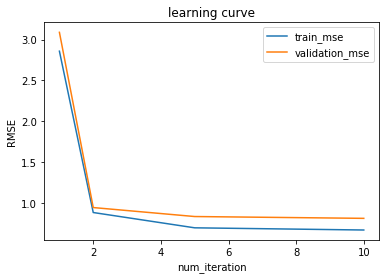

In [68]:
iter_array = [1, 2, 5, 10]
train_errors, val_errors = learning_curve(iter_array, training, validation, final_rank, final_reg)

plot_lr_curve(iter_array, train_errors, val_errors)

### Model testing
And finally, make a prediction and check the testing error.

In [69]:
rmse = rmse_evaluator.evaluate(final_model.transform(testing))
print('root of mean-squared error for testing data is: {}'.format(rmse))

root of mean-squared error for testing data is: 0.8168670224439818


### Apply the model to do recommendation

In [70]:
def get_recommend(recommend_to_user_df):
    recommend = (recommend_to_user_df
        .withColumn("tmp", arrays_zip("recommendations"))
        .withColumn("tmp", explode("tmp"))
        .select("userId", col("tmp.recommendations")['movieId'].alias('movieId'), col("tmp.recommendations")['rating'].alias('rating')))
    return recommend.join(movies, recommend.movieId==movies.movieId).select(recommend.userId, "title", "genres", "rating")

In [74]:
user_subset = ratings.where(ratings.userId == 1)
user_subset_recs = get_recommend(final_model.recommendForUserSubset(user_subset, 10))

print("recommendation to user 1:")
user_subset_recs.toPandas().head(10)

recommendation to user 1:


,userId,title,genres,rating
0,1,UFO - Distruggete base Luna!,Action|Sci-Fi|Thriller,6.833246
1,1,"District, The (Nyócker!)",Animation|Comedy,5.701684
2,1,Cuisine et dépendances,Comedy|Drama,5.631442
3,1,A Fat Wreck,Documentary,5.610677
4,1,The Postman's White Nights,(no genres listed),5.440829
5,1,The Pirates of Penzance,Adventure|Comedy,5.422235
6,1,Love Is Blind,Drama|Romance,5.406916
7,1,Ween Live in Chicago,Documentary,5.382915
8,1,The Mitten,Animation,5.382414
9,1,Mike Birbiglia: What I Should Have Said Was No...,Comedy,5.363551


## Step 4: Export ALS user and item factor vectors to Elasticsearch

In order to store the model in the correct format for the index mappings set up earlier, we need to write some utility functions which allow us to convert the raw vectors to the correct _delimited string format_. This ensures Elasticsearch will parse the vector field in the model correctly using the delimited token filter custom analyzer configured earlier.

### Utility functions for converting factor vectors

In [75]:
from pyspark.sql.types import *
from pyspark.sql.functions import udf, lit, current_timestamp, unix_timestamp

def convert_vector(x):
    '''Convert a list or numpy array to delimited token filter format'''
    return " ".join(["%s|%s" % (i, v) for i, v in enumerate(x)])

def reverse_convert(s):
    '''Convert a delimited token filter format string back to list format'''
    return  [float(f.split("|")[1]) for f in s.split(" ")]

def vector_to_struct(x, version, ts):
    '''Convert a vector to a SparkSQL Struct with string-format vector and version fields'''
    return (convert_vector(x), version, ts)

vector_struct = udf(vector_to_struct, \
                    StructType([StructField("factor", StringType(), True), \
                                StructField("version", StringType(), True),\
                                StructField("timestamp", LongType(), True)]))

In [77]:
# test out the vector conversion function
test_vec = final_model.userFactors.select("features").first().features
print(test_vec)
print()
print(convert_vector(test_vec))

[0.6450888514518738, 0.9105985164642334, 0.6369080543518066, -0.3509414792060852, -0.9060909748077393, 0.47838813066482544, 0.34185415506362915, 0.42779821157455444, -0.4276236891746521, -0.08414211869239807, 1.1605205535888672, -1.0112049579620361, -0.47937506437301636, -0.7154567837715149, 0.2307845652103424, -1.1488538980484009, 0.8359262347221375, 0.1366431564092636, -1.1939617395401, -0.5503947138786316]

0|0.6450888514518738 1|0.9105985164642334 2|0.6369080543518066 3|-0.3509414792060852 4|-0.9060909748077393 5|0.47838813066482544 6|0.34185415506362915 7|0.42779821157455444 8|-0.4276236891746521 9|-0.08414211869239807 10|1.1605205535888672 11|-1.0112049579620361 12|-0.47937506437301636 13|-0.7154567837715149 14|0.2307845652103424 15|-1.1488538980484009 16|0.8359262347221375 17|0.1366431564092636 18|-1.1939617395401 19|-0.5503947138786316


### Convert factor vectors to [factor, version, timestamp] form and write to Elasticsearch

In [78]:
ver = final_model.uid
ts = unix_timestamp(current_timestamp())
movie_vectors = final_model.itemFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
movie_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)
user_vectors = final_model.userFactors.select("id", vector_struct("features", lit(ver), ts).alias("@model"))
user_vectors.select("id", "@model.factor", "@model.version", "@model.timestamp").show(5)

+---+--------------------+----------------+----------+
| id|              factor|         version| timestamp|
+---+--------------------+----------------+----------+
| 10|0|0.3715067505836...|ALS_6db3ce0b7ec2|1579581420|
| 20|0|0.3286214768886...|ALS_6db3ce0b7ec2|1579581420|
| 30|0|0.1613766998052...|ALS_6db3ce0b7ec2|1579581420|
| 40|0|0.3396113812923...|ALS_6db3ce0b7ec2|1579581420|
| 50|0|0.3995991051197...|ALS_6db3ce0b7ec2|1579581420|
+---+--------------------+----------------+----------+
only showing top 5 rows

+---+--------------------+----------------+----------+
| id|              factor|         version| timestamp|
+---+--------------------+----------------+----------+
| 10|0|0.6450888514518...|ALS_6db3ce0b7ec2|1579581420|
| 20|0|0.8596282601356...|ALS_6db3ce0b7ec2|1579581420|
| 30|0|0.5042299032211...|ALS_6db3ce0b7ec2|1579581420|
| 40|0|1.0263648033142...|ALS_6db3ce0b7ec2|1579581420|
| 50|0|1.0743591785430...|ALS_6db3ce0b7ec2|1579581420|
+---+--------------------+--------------

In [79]:
# write data to ES, use:
# - "id" as the column to map to ES movie id
# - "update" write mode for ES, since you want to update new fields only
# - "append" write mode for Spark
movie_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "update") \
    .save("movies/doc", mode="append")

In [80]:
user_vectors.write.format("es") \
    .option("es.mapping.id", "id") \
    .option("es.write.operation", "index") \
    .save("users/doc", mode="append")

### Check the data  was written correctly

You can search for a movie to see if the model factor vector was written correctly. You should see a `'@model': {'factor': '0|...` field in the returned movie document.

In [81]:
# search for a particular sci-fi movie
es.search(index="movies", q="star wars phantom menace", size=1)['hits']['hits'][0]

{'_index': 'movies',
 '_type': 'doc',
 '_id': '2628',
 '_score': 21.247154,
 '_source': {'movieId': '2628',
  'title': 'Star Wars: Episode I - The Phantom Menace',
  'release_date': '1999',
  'genres': 'Action|Adventure|Sci-Fi',
  'tmdbId': '1893',
  '@model': {'factor': '0|-0.08328827470541 1|0.9240009188652039 2|0.3354133367538452 3|0.23696590960025787 4|-0.7063149213790894 5|-0.7392630577087402 6|0.3346553146839142 7|-0.34412291646003723 8|-0.4775799512863159 9|-0.32522183656692505 10|0.535256564617157 11|0.18055066466331482 12|0.12725631892681122 13|0.12734411656856537 14|0.22731855511665344 15|-0.3161265254020691 16|0.5739721059799194 17|0.11464138329029083 18|-0.4069567322731018 19|0.06041019409894943',
   'version': 'ALS_6db3ce0b7ec2',
   'timestamp': 1579581435},
  'id': 2628}}

## Step 5: Recommend using Elasticsearch!

Now we have loaded your recommendation model into Elasticsearch, we can generate some recommendations.

* Fetching movie posters from TMdb API
* Constructing the Elasticsearch [function score query](https://www.elastic.co/guide/en/elasticsearch/reference/5.3/query-dsl-function-score-query.html) to generate recommendations from trained ALS factor model
* Find the movies most similar to target movie to do recommendation.
* Given a user, use this query to find the movies with the highest predicted rating, to recommend to the user
* Display the results as an HTML table in Notebook

### Test if tmbd works

Successfully imported tmdbsimple!


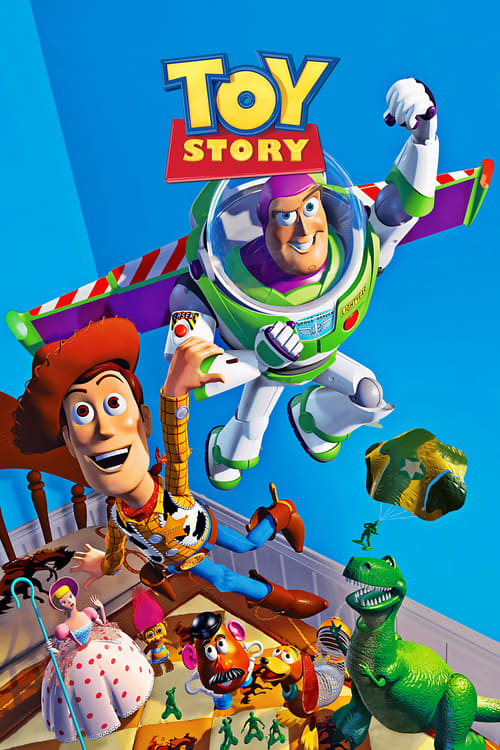

In [100]:
try:
    import tmdbsimple as tmdb
    # replace this variable with your actual TMdb API key
    tmdb.API_KEY = 'a3c65767f871b69d20752b89c2d97ae0'
    print("Successfully imported tmdbsimple!")
    # base URL for TMDB poster images
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    movie_id = movie_data.first().tmdbId
    movie_info = tmdb.Movies(movie_id).info()
    movie_poster_url = IMAGE_URL + movie_info['poster_path']
    display(Image(movie_poster_url, width=200))
except Exception:
    print("Cannot import tmdbsimple, no movie posters will be displayed!")

In [87]:
from IPython.display import Image, HTML, display

def get_poster_url(id):
    """Fetch movie poster image URL from TMDb API given a tmdbId"""
    IMAGE_URL = 'https://image.tmdb.org/t/p/w500'
    try:
        import tmdbsimple as tmdb
        from tmdbsimple import APIKeyError
        try:
            movie = tmdb.Movies(id).info()
            poster_url = IMAGE_URL + movie['poster_path'] if 'poster_path' in movie and movie['poster_path'] is not None else ""
            return poster_url
        except APIKeyError as ae:
            return "KEY_ERR"
    except Exception as me:
        return "NA"
    
    
def fn_query(query_vec, q="*", cosine=False):
    """
    Construct an Elasticsearch function score query.
    
    The query takes as parameters:
        - the field in the candidate document that contains the factor vector
        - the query vector
        - a flag indicating whether to use dot product or cosine similarity (normalized dot product) for scores
        
    The query vector passed in will be the user factor vector (if generating recommended movies for a user)
    or movie factor vector (if generating similar movies for a given movie)
    """
    return {
    "query": {
        "function_score": {
            "query" : { 
                "query_string": {
                    "query": q
                }
            },
            "script_score": {
                "script": {
                        "inline": "payload_vector_score",
                        "lang": "native",
                        "params": {
                            "field": "@model.factor",
                            "vector": query_vec,
                            "cosine" : cosine
                        }
                    }
            },
            "boost_mode": "replace"
        }
    }
}


def get_similar(the_id, q="*", num=10, index="movies"):
    """
    Given a movie id, execute the recommendation function score query to find similar movies, ranked by cosine similarity
    """
    response = es.get(index=index, doc_type='doc', id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=True)
        results = es.search(index, body=q)
        hits = results['hits']['hits']
        return src, hits[1:num+1]
    
    
def get_user_recs(the_id, q="*", num=10, index_user="users", index_movie="movies"):
    """
    Given a user id, execute the recommendation function score query to find top movies, ranked by predicted rating
    """
    response = es.get(index=index_user, doc_type='doc', id=the_id)
    src = response['_source']
    if '@model' in src and 'factor' in src['@model']:
        raw_vec = src['@model']['factor']
        # our script actually uses the list form for the query vector and handles conversion internally
        query_vec = reverse_convert(raw_vec)
        q = fn_query(query_vec, q=q, cosine=False)
        results = es.search(index_movie, body=q)
        hits = results['hits']['hits']
        return src, hits[:num]

def get_movies_for_user(the_id, num=10, index_rating="ratings", index_movie="movies"):
    """
    Given a user id, get the movies rated by that user, from highest- to lowest-rated.
    """
    response = es.search(index=index_rating, q="userId:%s" % the_id, size=num, sort=["rating:desc"])
    hits = response['hits']['hits']
    ids = [h['_source']['movieId'] for h in hits]
    movies = es.mget(body={"ids": ids}, index=index_movie, _source_include=['tmdbId', 'title'])
    movies_hits = movies['docs']
    tmdbids = [h['_source'] for h in movies_hits]
    return tmdbids

            
def display_user_recs(the_id, q="*", num=10, num_last=10):
    user, recs = get_user_recs(the_id, q, num)
    user_movies = get_movies_for_user(the_id, num_last)
    # check that posters can be displayed
    first_movie = user_movies[0]
    first_im_url = get_poster_url(first_movie['tmdbId'])
    if first_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if first_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    # display the movies that this user has rated highly
    display(HTML("<h2>Get recommended movies for user id %s</h2>" % the_id))
    display(HTML("<h4>The user has rated the following movies highly:</h4>"))
    user_html = "<table border=0>"
    i = 0
    for movie in user_movies:
        movie_im_url = get_poster_url(movie['tmdbId'])
        movie_title = movie['title']
        user_html += "<td><h5>%s</h5><img src=%s width=150></img></td>" % (movie_title, movie_im_url)
        i += 1
        if i % 5 == 0:
            user_html += "</tr><tr>"
    user_html += "</tr></table>"
    display(HTML(user_html))
    # now display the recommended movies for the user
    display(HTML("<br>"))
    display(HTML("<h2>Recommended movies:</h2>"))
    rec_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        rec_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            rec_html += "</tr><tr>"
    rec_html += "</tr></table>"
    display(HTML(rec_html))

    
def display_similar(the_id, q="*", num=10, index="movies"):
    """
    Display query movie, together with similar movies and similarity scores, in a table
    """
    movie, recs = get_similar(the_id, q, num, index)
    q_im_url = get_poster_url(movie['tmdbId'])
    if q_im_url == "NA":
        display(HTML("<i>Cannot import tmdbsimple. No movie posters will be displayed!</i>"))
    if q_im_url == "KEY_ERR":
        display(HTML("<i>Key error accessing TMDb API. Check your API key. No movie posters will be displayed!</i>"))
        
    display(HTML("<h2>Get similar movies for:</h2>"))
    display(HTML("<h4>%s</h4>" % movie['title']))
    if q_im_url != "NA":
        display(Image(q_im_url, width=200))
    display(HTML("<br>"))
    display(HTML("<h2>People who liked this movie also liked these:</h2>"))
    sim_html = "<table border=0>"
    i = 0
    for rec in recs:
        r_im_url = get_poster_url(rec['_source']['tmdbId'])
        r_score = rec['_score']
        r_title = rec['_source']['title']
        sim_html += "<td><h5>%s</h5><img src=%s width=150></img></td><td><h5>%2.3f</h5></td>" % (r_title, r_im_url, r_score)
        i += 1
        if i % 5 == 0:
            sim_html += "</tr><tr>"
    sim_html += "</tr></table>"
    display(HTML(sim_html))

### 5(a) Find similar movies for a given movie

Using this similarity we can show recommendations along the lines of _people who liked this movie also liked these_.

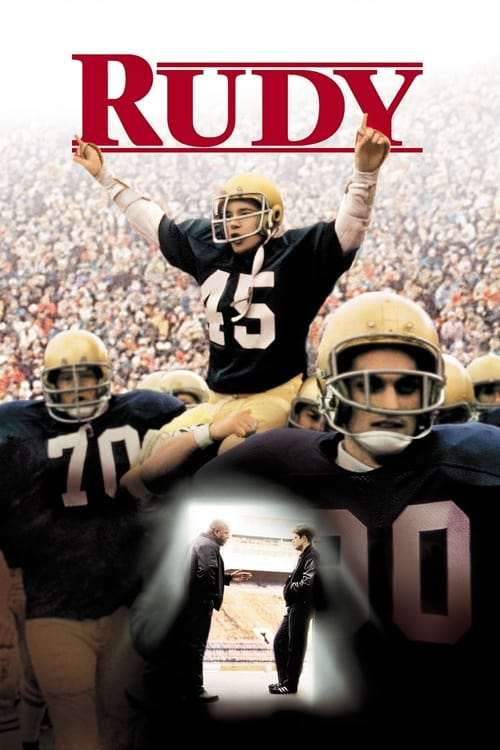

In [89]:
display_similar(524, num=5)

Now we will see the power and flexibility that comes from using a search engine to generate recommendations. Elasticsearch allows us to tweak the results returned by the recommendation query using any standard search query or filter - from free text search through to filters based on time and geo-location.

For example, perhaps we want to remove any movies with "Ocean" in the title from the recommendations. We can do this by simply passing a valid Elasticsearch query string to the recommendation function.

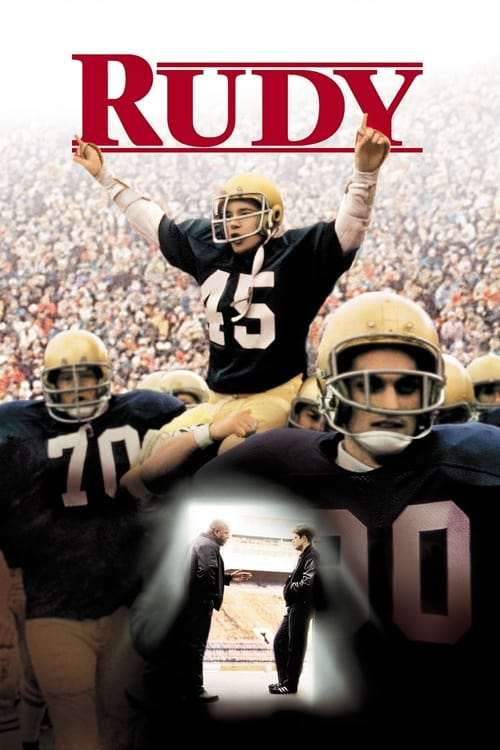

In [90]:
display_similar(524, num=5, q="title:(NOT Ocean)")

Or we'd like to ensure that only Drama movies are shown to us.

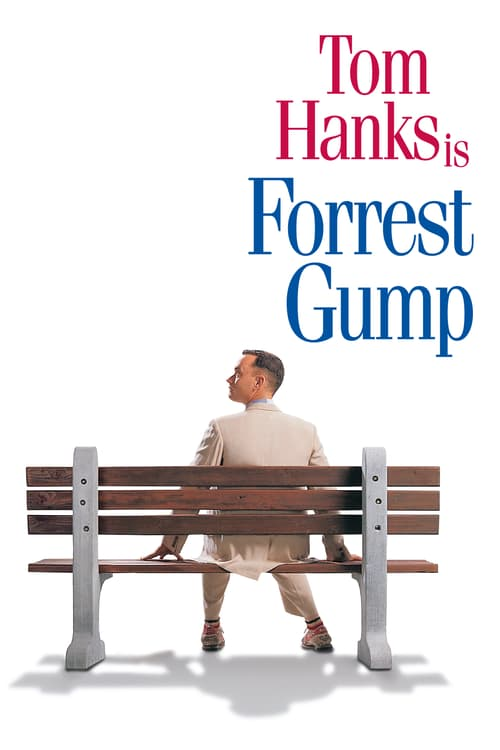

In [93]:
display_similar(356, num=5, q="genres:Drama")

### 5(b) Find movies to recommend to a user

It's time to generate some movie recommendations, personalized for a specific user.


In [97]:
display_user_recs(1, num=5, num_last=5)

In this case, we only want to recommend more recent movies (release year after 2012).

In [95]:
display_user_recs(1, num=5, num_last=5, q="release_date:[2012 TO *]")

## __References:__
* [elasticsearch-spark-recommender](https://github.com/IBM/elasticsearch-spark-recommender)